# Описание проекта: промышленность
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.
## Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).
## Описание данных
Данные состоят из файлов, полученных из разных источников:
* data_temp_new.csv — результаты измерения температуры;
    - Номер партии
    - время замера
    - температура замера
* data_arc_new.csv — данные об электродах;
    - Номер партии
    - начало нагрева
    - конец нагрева
    - расход активной энергии
    - расход реактивной энергии
* data_gas_new.csv — данные о продувке сплава газом;
    - Номер партии
    - совокупный расход газа на партию
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
    - Номер партии
    - время применения материала(15 видов)
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
    - Номер партии
    - объем материала(15 видов)
* data_wire_time_new.csv — данные о проволочных материалах (время).
    - Номер партии
    - время применения материала(9 видов)
* data_wire_new.csv — данные о проволочных материалах (объём);
    - Номер партии
    - объем материала(9 видов)

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Цель проекта

Оптимизировать затраты электроэнергии путем предсказания конечной тепературы сырья.
Для успешного выполнения проектка требуется достичь метрики MAE <6.8

## План проекта
### Препроцессинг
* Удалить партии: с неизмеренной температурой, с отрицательными значениями мощности, с одним измерением температуры, со значениями температуры <1500
* Пересчиать мощность в абсолютные значения
* Выделить первый и последний замер в проверке температур
* Посчитать совокупный объем сыпучих метериалов и количество проволоки
* Слепить данные в единую таблицу
* Убрать ключи
* Вывести корреляцию призаков
* Разобраться с мультиколлинеарными признаками
* Визуализировать значения признаков
* Поделить датасет
* Отскалировать фичи

### Построение моделей
* Построить модель случайного леса с перебором гиперпараметров
* Построить модель градиентного бустинга с перебором гиперпараметров
* Построить дамми модель
* Выделить сильную модель

### Подведение итогов
* Проверить модель на тестовой выборке
* Изучить процесс обучения
* Провести дамми тест
* Провести анализ важности фичей 
* Подвести итог работы

## Разведочный анализ данных

In [28]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
RND_SEED = 250923

In [29]:
starttime = time.time()
path1 = '/datasets/'
path2 = '/Users/evgeniu/Desktop/Рабочий стол — MacBook Pro — Евгений/Education/Practicum /Industry_optimization/Dataset/'
path3 = r'C:\Users\dev\Desktop\Industry_optimization\Dataset\\'[:-1]
#files = os.listdir(path2)

def get_data(path):
    data = {}
    for file in ['data_gas_new.csv', 'data_wire_time_new.csv', 
                'data_wire_new.csv', 'data_bulk_time_new.csv', 
                'data_bulk_new.csv', 'data_arc_new.csv', 'data_temp_new.csv']:
        data[file] = pd.read_csv(path+file, encoding = "utf-8")
    return data
#for path in [path1, path2, path3]:
if os.path.exists(path1):
    data = get_data(path1)
elif os.path.exists(path2):
    data = get_data(path2)
elif os.path.exists(path3):
    data = get_data(path3)
len(data.keys())

7

Загружено 7 файлов, изучим их:

### Data.info

In [30]:
for key in data.keys():
    print('{:=^40}'.format(key))
    print(data[key].info(), '\n')

============data_gas_new.csv============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None 

=========data_wire_time_new.csv=========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None 

========

В данных имеем не очень удобный нейминг столбцов. Исправим это. В датасете две пары таблиц (подача провлоки и примесей) которые тесно связаны. У этих таблиц совпадает количество пропусков. 
Часть данных измерений температур отсутствует. Позже рассмотрим причины потерь.

In [31]:
#Переименум столбцы
def name_refactoring(col):
    new_col = []
    for name in col:
        new_col.append(name.lower().replace(' ', '_'))
    return new_col

In [32]:
data['data_gas_new.csv'].columns = ('key', 'gas')
data['data_arc_new.csv'].columns = ('key', 'start_heating_stamp', 'stop_heating_stamp', 'active_power', 'reactive_power')
data['data_temp_new.csv'].columns = ('key', 'probe_stamp', 'temp')
for table in (data['data_bulk_new.csv'], 
              data['data_bulk_time_new.csv'],
              data['data_wire_new.csv'],
              data['data_wire_time_new.csv']):
    table.columns = name_refactoring(table.columns)

### Data.head

In [33]:
for key in data.keys():
    print('{:=^40}'.format(key))
    display(data[key].head(7))

============data_gas_new.csv============


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267


=========data_wire_time_new.csv=========


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===========data_wire_new.csv============


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=========data_bulk_time_new.csv=========


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16


===========data_bulk_new.csv============


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0


============data_arc_new.csv============


,key,start_heating_stamp,stop_heating_stamp,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527


===========data_temp_new.csv============


,key,probe_stamp,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0


В данных предствлено много дат, их стоит привести к формату datetime(). Похоже пустые значения означают что подача не была задействована в операции.

In [34]:
def to_dt(name, col):    
    data[name][col] = pd.to_datetime(data[name][col], format='%Y-%m-%d %H:%M:%S')

In [35]:
to_dt('data_arc_new.csv', 'start_heating_stamp')
to_dt('data_arc_new.csv', 'stop_heating_stamp')
to_dt('data_temp_new.csv', 'probe_stamp')


In [36]:
columns = data['data_bulk_time_new.csv'].columns
for col in columns[1:]:
    to_dt('data_bulk_time_new.csv', col)

In [37]:
columns = data['data_wire_time_new.csv'].columns
for col in columns[1:]:
    to_dt('data_wire_time_new.csv', col)

In [38]:
data['data_bulk_time_new.csv'].isna().isin(data['data_bulk_new.csv'].isna()).value_counts()

key   bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15
True  True    True    True    True    True    True    True    True    True    True     True     True     True     True     True       3129
dtype: int64

In [39]:
data['data_wire_time_new.csv'].isna().isin(data['data_wire_new.csv'].isna()).value_counts()

key   wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9
True  True    True    True    True    True    True    True    True    True      3081
dtype: int64

Пропуски в зависимых таблицах, описывающих подачу материала, полностью совпадают. Нарушений не обнаружено.

In [40]:
data['data_temp_new.csv'][data['data_temp_new.csv']['temp'].isna()].head(5)

,key,probe_stamp,temp
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN


In [41]:
len(data['data_temp_new.csv'][data['data_temp_new.csv']['temp'].isna()]['key'].unique())

739

739 партий имеют пропуски в значениях температуры при измерении. Похоже почти все потери начинаются с 2500 партии. Возможно это ошибка выгрузки или ошибка в ведении логов процессов.

In [42]:
print('Количество партий в наборе данных измерения темепратуры: {}'.format(len(data['data_temp_new.csv']['key'].unique())))

Количество партий в наборе данных измерения темепратуры: 3216


Количество партий в таблице варьируется в диапазоне от 3080 до 3239. Самый скудный набор оказался в таблице измерения температур т.к в нем большие потери измерений. При склеивании датасета ее стоит взять за основу.

### Data.describe

In [43]:
for key in data.keys():
    print('{:=^40}'.format(key))
    print(data[key].describe(), '\n')

============data_gas_new.csv============
               key          gas
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040 

=========data_wire_time_new.csv=========
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000 

===========data_wire_new.csv============
               key       wire_1       wire_2      wire_3      wire_4  wire_5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.00

* Газ: в среднем тратится 11 единиц(м3) газа на партию. Распределение данных похоже на нормальное.
* Подача проволоки и сыпучих материалов: в данных развернуто зафиксирован тип и объем подаваемых материалов. Некоторые операции выполняются очень редко, видимо, по особым случаям. Понимать какой материал высыпали или какую провлоку ввели на не обязательно в рамках текущей задачи. Возможно для обучения моделей будет достаточно общего объема подаваемых материалов отдельно для проволоки и сыпучих материалов.
* Нагревательная дуга: Хранит показания использованной активной и реактивной энергии. Значения реактивной энергии есть отрицательные. Заказчик предупредил об этих выбросах и предложил удалить партии с аномалиями.
* Температура: Фиксирована в диапазоне 1191-1705, но обычно материал разогрет в диапазоне 1580-1600 градусов. Для партий где значения проб ниже 1500 градусов заказчил пропросил не использовать показания т.к. в таких условиях операции совершать нельзя.

#### Собирательное представление варок

In [44]:
def get_process_line(part):
    tables = {}
    for key in data.keys():
        tables[key] = (data[key][data[key]['key']== part])
    tables['data_bulk_concat'] = pd.concat([tables['data_bulk_time_new.csv'], tables['data_bulk_new.csv']]).dropna(axis=1)
    tables['data_wire_concat'] = pd.concat([tables['data_wire_time_new.csv'], tables['data_wire_new.csv']]).dropna(axis=1)
    for value in ('data_bulk_new.csv', 'data_wire_new.csv', 'data_wire_time_new.csv', 'data_bulk_time_new.csv'):
        tables.pop(value)
    for key in tables.keys():
        tables[key] = tables[key].drop('key', axis=1)
    return tables

In [45]:
# Номер партии:
BATCH = 456

operation = get_process_line(BATCH)
for key in operation.keys():
    display(operation[key])

,gas
453,6.745702


,start_heating_stamp,stop_heating_stamp,active_power,reactive_power
2121,2019-05-20 19:54:41,2019-05-20 19:56:50,0.580291,0.424299
2122,2019-05-20 20:00:35,2019-05-20 20:05:23,0.507558,0.343649
2123,2019-05-20 20:07:25,2019-05-20 20:09:37,0.410166,0.253115
2124,2019-05-20 20:13:57,2019-05-20 20:15:45,1.213249,0.826133
2125,2019-05-20 20:20:16,2019-05-20 20:21:15,0.402317,0.269076


,probe_stamp,temp
2572,2019-05-20 19:54:31,1574.0
2573,2019-05-20 20:00:25,1589.0
2574,2019-05-20 20:07:15,1588.0
2575,2019-05-20 20:13:47,1581.0
2576,2019-05-20 20:20:06,1586.0
2577,2019-05-20 20:24:55,1587.0


,bulk_3,bulk_12,bulk_14,bulk_15
430,2019-05-20 20:21:31,2019-05-20 20:16:00,2019-05-20 20:09:47,2019-05-20 20:05:39
430,116.0,314.0,202.0,175.0


,wire_1
424,2019-05-20 19:57:04
424,68.140801


В данном выводе можно изучить информацию об операциях для выбраной партии. Вывод склеивает подачу материалов в одну таблицу и убирает лишние пустые столбцы.

#### Длительность варок

In [46]:
def first_last_div(df):
    return df.iloc[-1] - df.iloc[0]
operation_duration = data['data_temp_new.csv'].groupby(['key'])['probe_stamp'].apply(first_last_div)

In [47]:
#Перевод timestamp в минуты
operation_duration = pd.to_numeric(operation_duration).apply(lambda x: x/(10 ** 9)/ 60)

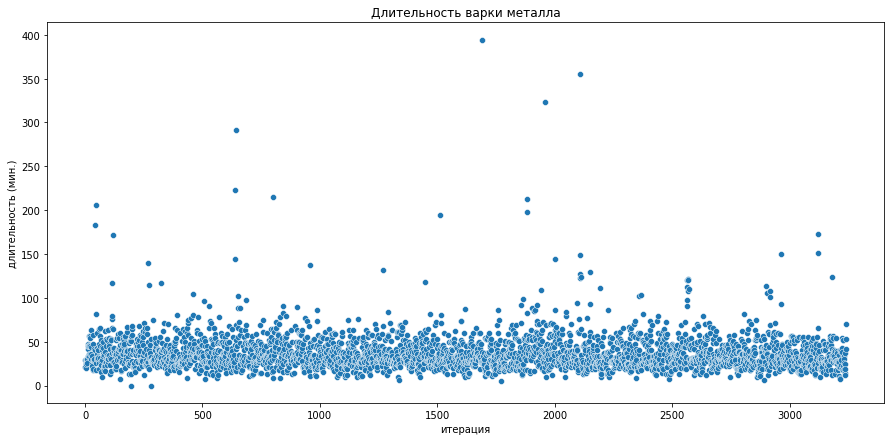

In [48]:

plt.figure(figsize=(15,7))
sns.scatterplot(y=operation_duration, x=operation_duration.index)
plt.title("Длительность варки металла")
plt.xlabel('итерация')
plt.ylabel('длительность (мин.)');
#plt.show()

Длительность варки металла обычно занимает 15-70 минут, но бывают более сложные составы, которые выводят на выплавку через 90+ минут.

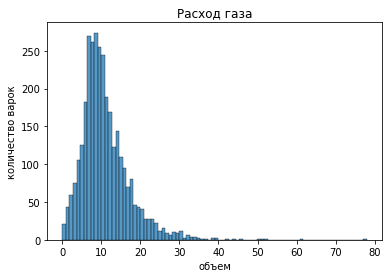

In [49]:
# data['data_gas_new.csv'].sort_values(by='gas').plot(y='gas', kind='bar')
sns.histplot(data['data_gas_new.csv'], x='gas')
plt.title('Расход газа')
plt.xlabel('объем')
plt.ylabel('количество варок');
#plt.show()

Расход газа имеет распределение смещенное влево, на некоторые варки его расхо был очень большим

Text(0.5, 0.98, 'Распределение первой и последней температуры варки')

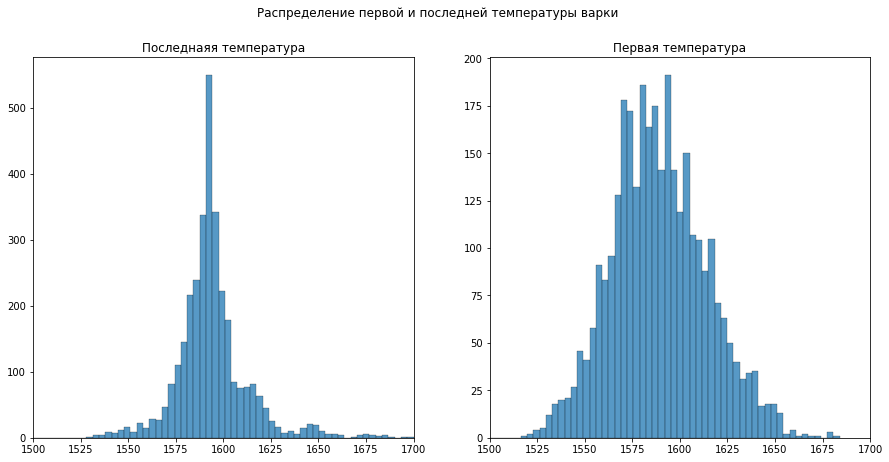

In [50]:
temp = data['data_temp_new.csv'][['key','temp']].groupby(['key']).agg(['first', 'last'])#.columns=['first', 'last']
temp.columns=['first', 'last']
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
#plt.figure(figsize=(15,7))
sns.histplot(temp, x='last', ax=ax1, bins=150)
sns.histplot(temp, x='first', ax=ax2, bins=150)
ax1.set_title('Последнаяя температура')
ax2.set_title('Первая температура')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_xlim(1500,1700)
ax2.set_xlim(1500,1700)
#f.supylabel('количество')
#f.supxlabel('температура')
f.suptitle('Распределение первой и последней температуры варки')

В конце варки металл имеет температуру 1570-1605 градусов, на входе разброс шире.

В ходе разведывательного анализа дынных определен состав данных, выделены их особенности и отклонения.

## Preprocessing

In [51]:
#Подготовленные таблицы пишем сюда
data_clean = {}

### Чистим Nan

In [52]:
one_probe_keys = data['data_temp_new.csv'].groupby(['key'])['temp'].count() 
one_probe_keys = one_probe_keys[one_probe_keys<=1].index
data_clean['data_temp.csv'] = data['data_temp_new.csv'][~data['data_temp_new.csv']['key'].isin(one_probe_keys)]
#data['data_temp_new.csv'].drop(data['data_temp_new.csv'].groupby(['key'])['temp'].count() <= 1)
print('После чистки осталось {} партий, удалено {} партий'.format(len(data_clean['data_temp.csv']['key'].unique()), len(one_probe_keys)))

После чистки осталось 2475 партий, удалено 741 партий


In [53]:
low_temp_key = data_clean['data_temp.csv'][data_clean['data_temp.csv']['temp'] < 1500]['key'].values
data_clean['data_temp.csv'] = data_clean['data_temp.csv'][~data_clean['data_temp.csv']['key'].isin(low_temp_key)]
print('После чистки осталось {} партий, удалено {} партий'.format(len(data_clean['data_temp.csv']['key'].unique()), len(low_temp_key)))

После чистки осталось 2471 партий, удалено 4 партий


In [54]:
data_clean['data_temp.csv'].tail(5)

,key,probe_stamp,temp
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0
13925,2499,2019-08-10 13:58:58,1603.0


In [55]:
data_clean['data_temp.csv'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          13903 non-null  int64         
 1   probe_stamp  13903 non-null  datetime64[ns]
 2   temp         13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


Пустых записей измерений температуры не осталось. Удалено 745 партий. потери большие, но придется работать с чем есть. Заказчику стоит отладить процесс сбора и хранения температуры, тогда, возможно, он сможет лучше оптимизировать производство.

In [56]:
bad_power = data['data_arc_new.csv'][(data['data_arc_new.csv']['active_power'] < 0) | (data['data_arc_new.csv']['reactive_power'] < 0)]['key'].values
data_clean['data_arc.csv'] = data['data_arc_new.csv'][~data['data_arc_new.csv']['key'].isin(bad_power)]
print('После чистки осталось {} партий, удалено {} партий'.format(len(data_clean['data_arc.csv']['key'].unique()), len(bad_power)))

После чистки осталось 3213 партий, удалено 1 партий


### Агрегируем энергию

In [57]:
# Рассчитываем полную мощность, считаем продолжительность нагрева в секундах, удаляем агрегированные столбцы
data_clean['data_arc_total.csv'] = data_clean['data_arc.csv'].loc[:, ('key', 'start_heating_stamp', 'stop_heating_stamp')]
data_clean['data_arc_total.csv']['total_power'] = np.sqrt(data_clean['data_arc.csv']['active_power']**2 + data_clean['data_arc.csv']['reactive_power']**2)
data_clean['data_arc_total.csv']['power_time_delta'] = pd.to_numeric(data_clean['data_arc_total.csv']['stop_heating_stamp'] - data_clean['data_arc_total.csv']['start_heating_stamp']) /10**9
#data_clean['data_arc_total.csv']['work'] = data_clean['data_arc_total.csv']['total_power']*data_clean['data_arc_total.csv']['power_time_delta']
data_clean['data_arc_total.csv'] = data_clean['data_arc_total.csv'].drop(['stop_heating_stamp', 'start_heating_stamp'], axis=1)
data_clean['data_arc_total.csv'].head(5)

,key,total_power,power_time_delta
0,1,0.371123,228.0
1,1,0.902319,185.0
2,1,0.722536,172.0
3,1,0.642824,365.0
4,1,1.079934,148.0


In [58]:
#Суммируем показатели затраченной мощности и времени по каждой партии
data_clean['data_arc.csv'] = data_clean['data_arc_total.csv'].groupby('key').agg('sum')
data_clean['data_arc.csv'].head(5)

,total_power,power_time_delta
key,,
1,3.718736,1098.0
2,2.588349,811.0
3,5.019223,655.0
4,3.400038,741.0
5,2.816980,869.0


### Агрегируем температуру

In [59]:
#выделяем первый и последний замер температур, удаляем ненужные столбцы
data_clean['data_temp.csv'] = data_clean['data_temp.csv'].groupby(['key']).agg(['first', 'last'])
data_clean['data_temp.csv']['time_delta'] = pd.to_numeric(data_clean['data_temp.csv']['probe_stamp', 'last']-data_clean['data_temp.csv']['probe_stamp', 'first']) / 10**9
data_clean['data_temp.csv'] = data_clean['data_temp.csv'].drop('probe_stamp', axis=1)
data_clean['data_temp.csv'].columns = ['temp_first', 'temp_last', 'temp_time_delta']
data_clean['data_temp.csv'].head(5)

,temp_first,temp_last,temp_time_delta
key,,,
1,1571.0,1613.0,1714.0
2,1581.0,1602.0,1265.0
3,1596.0,1599.0,1753.0
4,1601.0,1625.0,1220.0
5,1576.0,1602.0,1536.0


### Сокращаем добавки

In [60]:
data_clean['data_bulk.csv'] = data['data_bulk_new.csv'].groupby(['key']).agg('sum')
#data_clean['data_bulk.csv']['bulk_input_count'] = data_clean['data_bulk.csv'][data_clean['data_bulk.csv'] > 0].apply('count', axis=1)
data_clean['data_bulk.csv'].head(5)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [61]:
data_clean['data_wire.csv'] = data['data_wire_new.csv'].groupby(['key']).agg('sum')
#data_clean['data_wire.csv']['wire_input_count'] = data_clean['data_wire.csv'][data_clean['data_wire.csv'] > 0].apply('count', axis=1)
data_clean['data_wire.csv'].head(5)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
#Плотность заполнения значений по подаче проволоки
wire_density = data_clean['data_wire.csv'][data_clean['data_wire.csv']>0].count() / data_clean['data_wire.csv'].shape[0] * 100
wire_density

wire_1    99.156118
wire_2    35.021097
wire_3     2.044791
wire_4     0.454398
wire_5     0.032457
wire_6     2.369361
wire_7     0.357027
wire_8     0.616683
wire_9     0.941253
dtype: float64

In [63]:
#Плотность заполнения по подаче примесей
bulk_density = data_clean['data_bulk.csv'][data_clean['data_bulk.csv']>0].count() / data_clean['data_bulk.csv'].shape[0] * 100
bulk_density

bulk_1      8.053691
bulk_2      0.703100
bulk_3     41.482902
bulk_4     32.406520
bulk_5      2.460850
bulk_6     18.408437
bulk_7      0.798977
bulk_8      0.031959
bulk_9      0.607223
bulk_10     5.624800
bulk_11     5.656759
bulk_12    78.299776
bulk_13     0.575264
bulk_14    89.677213
bulk_15    71.844040
dtype: float64

В процессе варки добавляемые примеси имеют разную частоту применения, есть регулярно используемые компоненты и компоненты которые используются редко. Поведение металла на редких компонентах трудно оценить, по-этому принято решение упаковать компоненты, заполненность которых < 20%, в столбец other

In [64]:
wire_density = wire_density[wire_density<20]
bulk_density = bulk_density[bulk_density<20]

In [65]:
data_clean['data_bulk.csv']['other_bulk'] = data_clean['data_bulk.csv'][bulk_density.index].sum(axis=1)
data_clean['data_bulk.csv'] = data_clean['data_bulk.csv'].drop(bulk_density.index, axis=1)
data_clean['data_bulk.csv'].head(5)

,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,other_bulk
key,,,,,,
1,0.0,43.0,206.0,150.0,154.0,0.0
2,0.0,73.0,206.0,149.0,154.0,0.0
3,0.0,34.0,205.0,152.0,153.0,0.0
4,0.0,81.0,207.0,153.0,154.0,0.0
5,0.0,78.0,203.0,151.0,152.0,0.0


In [66]:
data_clean['data_wire.csv']['other_wire'] = data_clean['data_wire.csv'][wire_density.index].sum(axis=1)
data_clean['data_wire.csv'] = data_clean['data_wire.csv'].drop(wire_density.index, axis=1)
data_clean['data_wire.csv'].head(5)

,wire_1,wire_2,other_wire
key,,,
1,60.059998,0.00000,0.0
2,96.052315,0.00000,0.0
3,91.160157,0.00000,0.0
4,89.063515,0.00000,0.0
5,89.238236,9.11456,0.0


### Создание единого датасета

In [67]:
fdata = data_clean['data_temp.csv'].merge(data['data_gas_new.csv'], how='inner', on='key')
fdata = fdata.merge(data_clean['data_wire.csv'], how='inner', on='key')
fdata = fdata.merge(data_clean['data_bulk.csv'], how='inner', on='key')
fdata = fdata.merge(data_clean['data_arc.csv'], how='inner', on='key')
fdata = fdata.drop('key', axis=1)
fdata

,temp_first,temp_last,temp_time_delta,gas,wire_1,wire_2,other_wire,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,other_bulk,total_power,power_time_delta
0,1571.0,1613.0,1714.0,29.749986,60.059998,0.00000,0.0,0.0,43.0,206.0,150.0,154.0,0.0,3.718736,1098.0
1,1581.0,1602.0,1265.0,12.555561,96.052315,0.00000,0.0,0.0,73.0,206.0,149.0,154.0,0.0,2.588349,811.0
2,1596.0,1599.0,1753.0,28.554793,91.160157,0.00000,0.0,0.0,34.0,205.0,152.0,153.0,0.0,5.019223,655.0
3,1601.0,1625.0,1220.0,18.841219,89.063515,0.00000,0.0,0.0,81.0,207.0,153.0,154.0,0.0,3.400038,741.0
4,1576.0,1602.0,1536.0,5.413692,89.238236,9.11456,0.0,0.0,78.0,203.0,151.0,152.0,0.0,2.816980,869.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,1570.0,1591.0,1380.0,7.125735,89.150879,0.00000,0.0,21.0,0.0,256.0,129.0,223.0,90.0,3.868721,723.0
2320,1554.0,1591.0,1705.0,9.412616,114.179527,0.00000,0.0,0.0,63.0,256.0,129.0,226.0,122.0,5.070316,940.0
2321,1571.0,1589.0,962.0,6.271699,94.086723,9.04800,0.0,0.0,85.0,230.0,124.0,226.0,0.0,4.360918,569.0
2322,1591.0,1594.0,1520.0,14.953657,118.110717,0.00000,0.0,90.0,0.0,206.0,129.0,207.0,101.0,3.909917,750.0


### Распределение признаков

In [68]:
columns_name = ['Температура при первом замере', 'Температура при последнем замере', 
                'Длительность варки', 'Объем газа', 'Проволока 1', 'Проволока 2',
                'Прочие проволоки', 'Сыпучий материал 3', 'Сыпучий материал 4', 'Сыпучий материал 12', 
                'Сыпучий материал 14', 'Сыпучий материал 15',
                'Прочий сыпучий материал', 'Затраченая энергия', 'Время работы электродов']

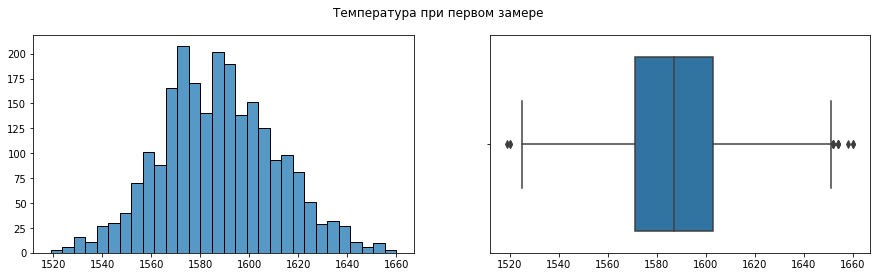

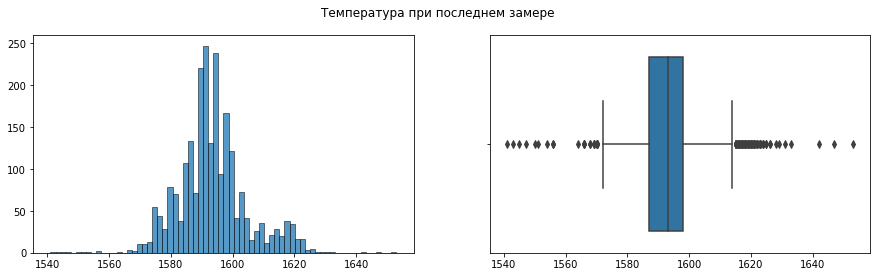

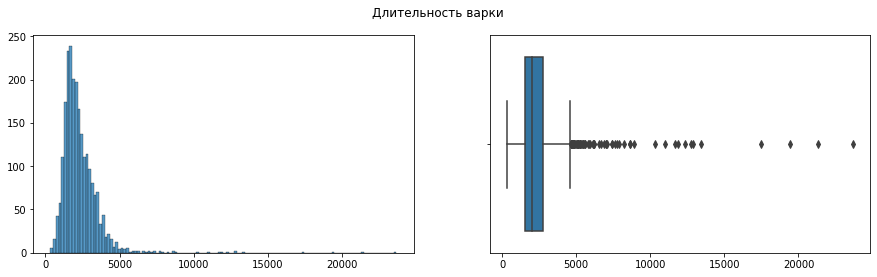

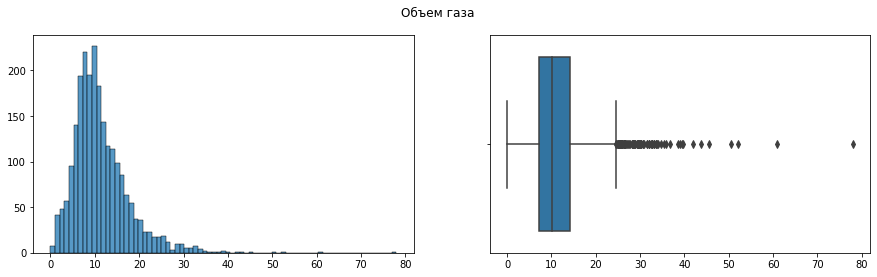

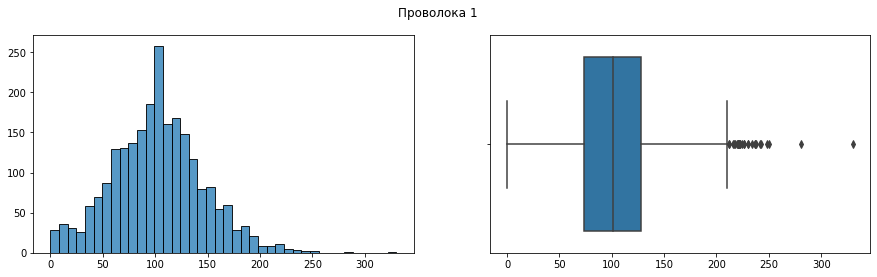

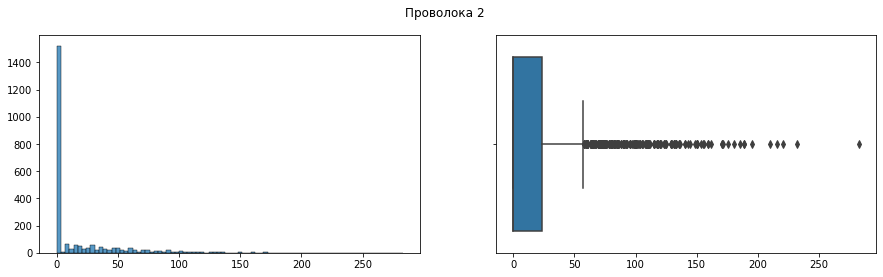

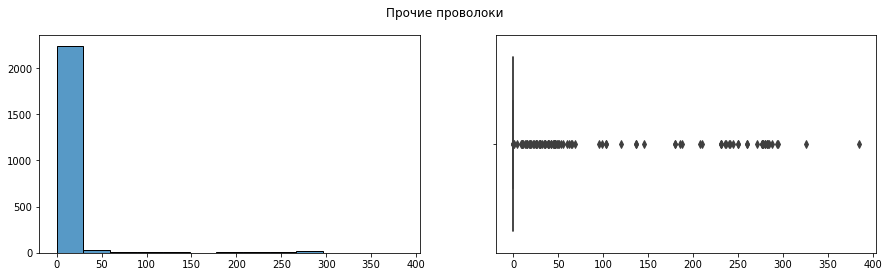

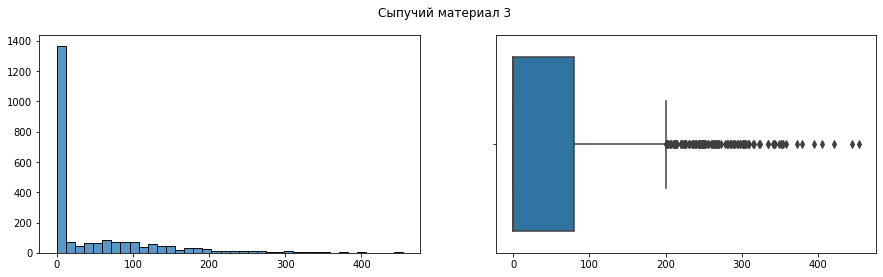

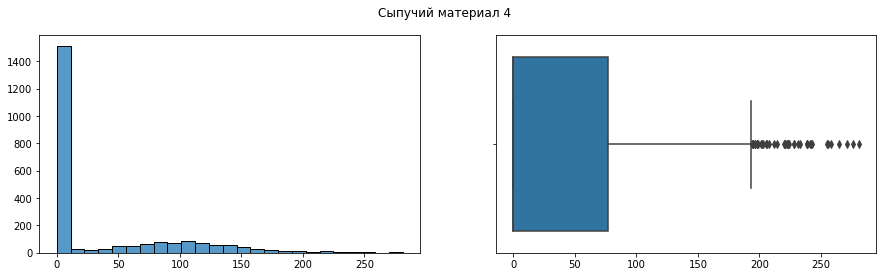

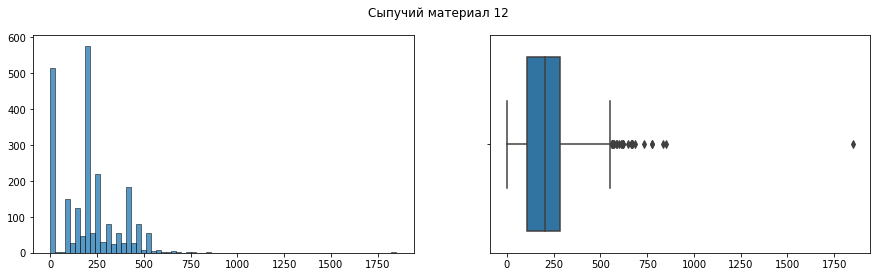

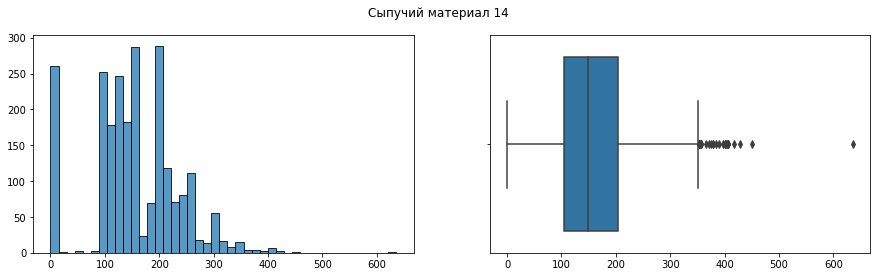

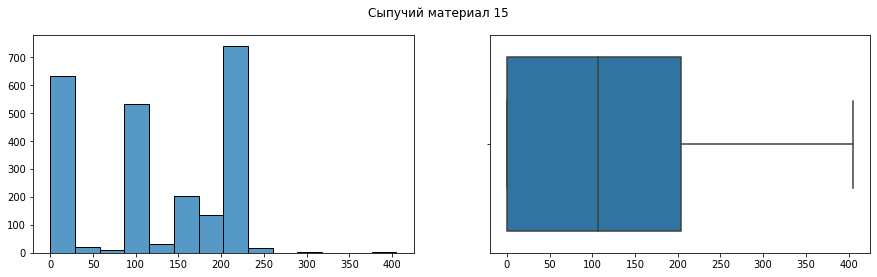

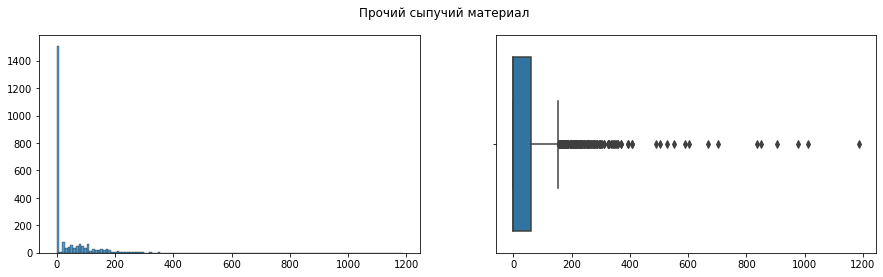

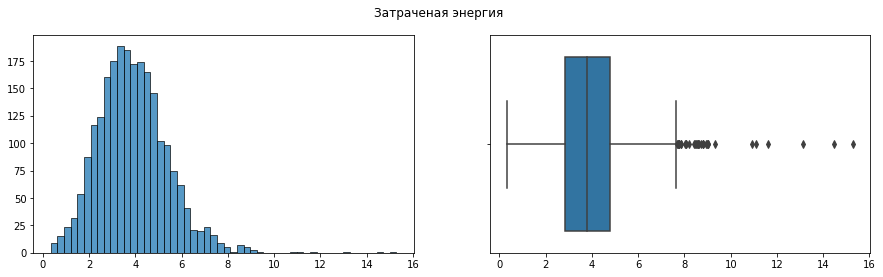

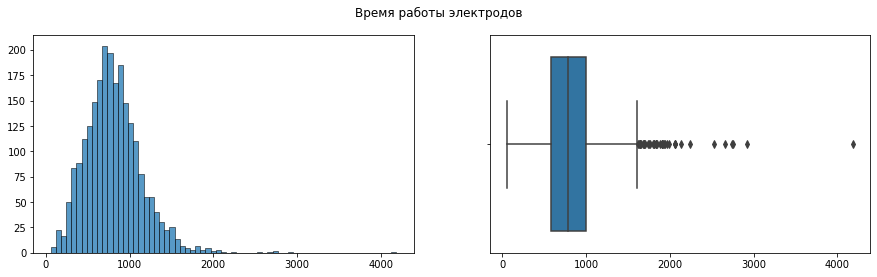

In [69]:
for col in range(len(fdata.columns)):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    sns.histplot(fdata, ax=ax1, x=fdata.iloc[:,col])
    sns.boxplot(ax=ax2, x=fdata.iloc[:,col])
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax2.set_xlabel('')
    f.suptitle(columns_name[col])
    #plt.show()

* Температура: температура на входе имеет хорошую кучность и нормальное распределение, чего нельзя сказать об выходной температуре. Возможно металл сливался с нарушением температурного режима, либо отдельные варки, в силу специфики процесса, требовали таких отклонений;
* Интервал варки: есть процессы которые сильно дольше протекали, возможно они помешают хорошему обучению
* Объем газа: аналогичная ситуация с распределением, дольше варка - больше газа
* Проволока и сыпучие материалы: имеют большие столбы на отметке 0 а так-же на уровне объемов примесей для типичных составов металла
* Работа электродов: Затраченная энергия и время работы распределены нормально, с хвостами для долгих процессов.
Саммари: Есть длительные процессы которые вешают хвосты на респределениях, возможно примеси лучше подавать моделям единой суммой

### Тепловая карта корреляций

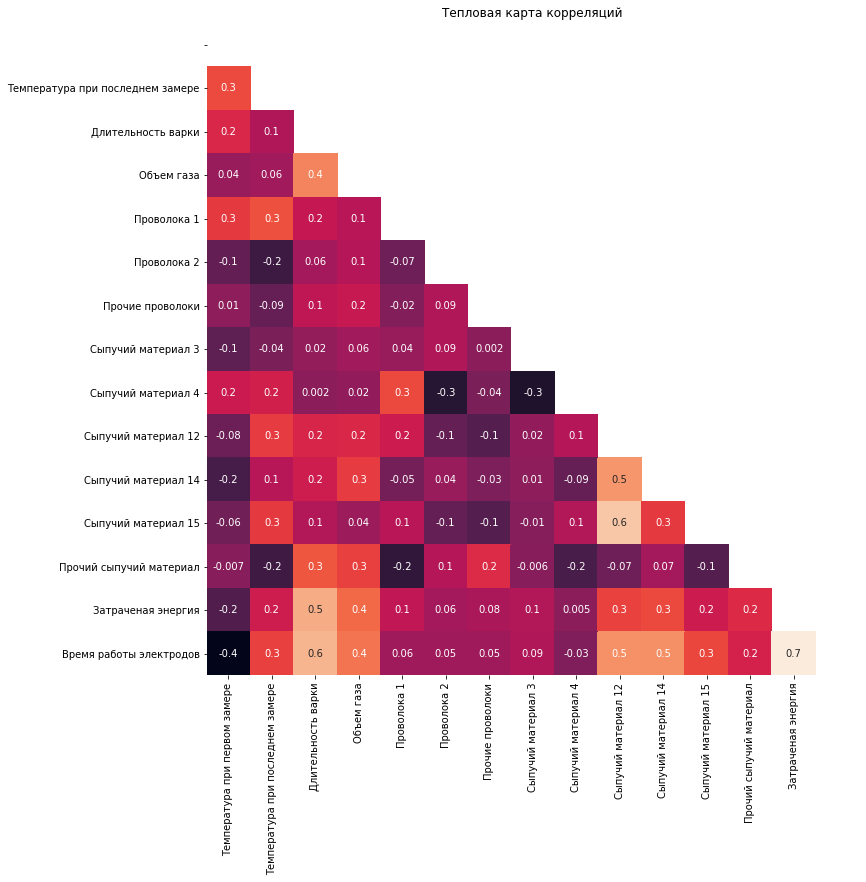

In [70]:
matrix = np.triu(fdata.corr())
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(fdata.corr(), annot=True, fmt='.1g', cbar=False, square=True, mask=matrix, 
            xticklabels=columns_name[:-1], yticklabels=[None] + columns_name[1:])
ax.set_title('Тепловая карта корреляций');
#plt.figure(figsize=(15,15))
#plt.show()

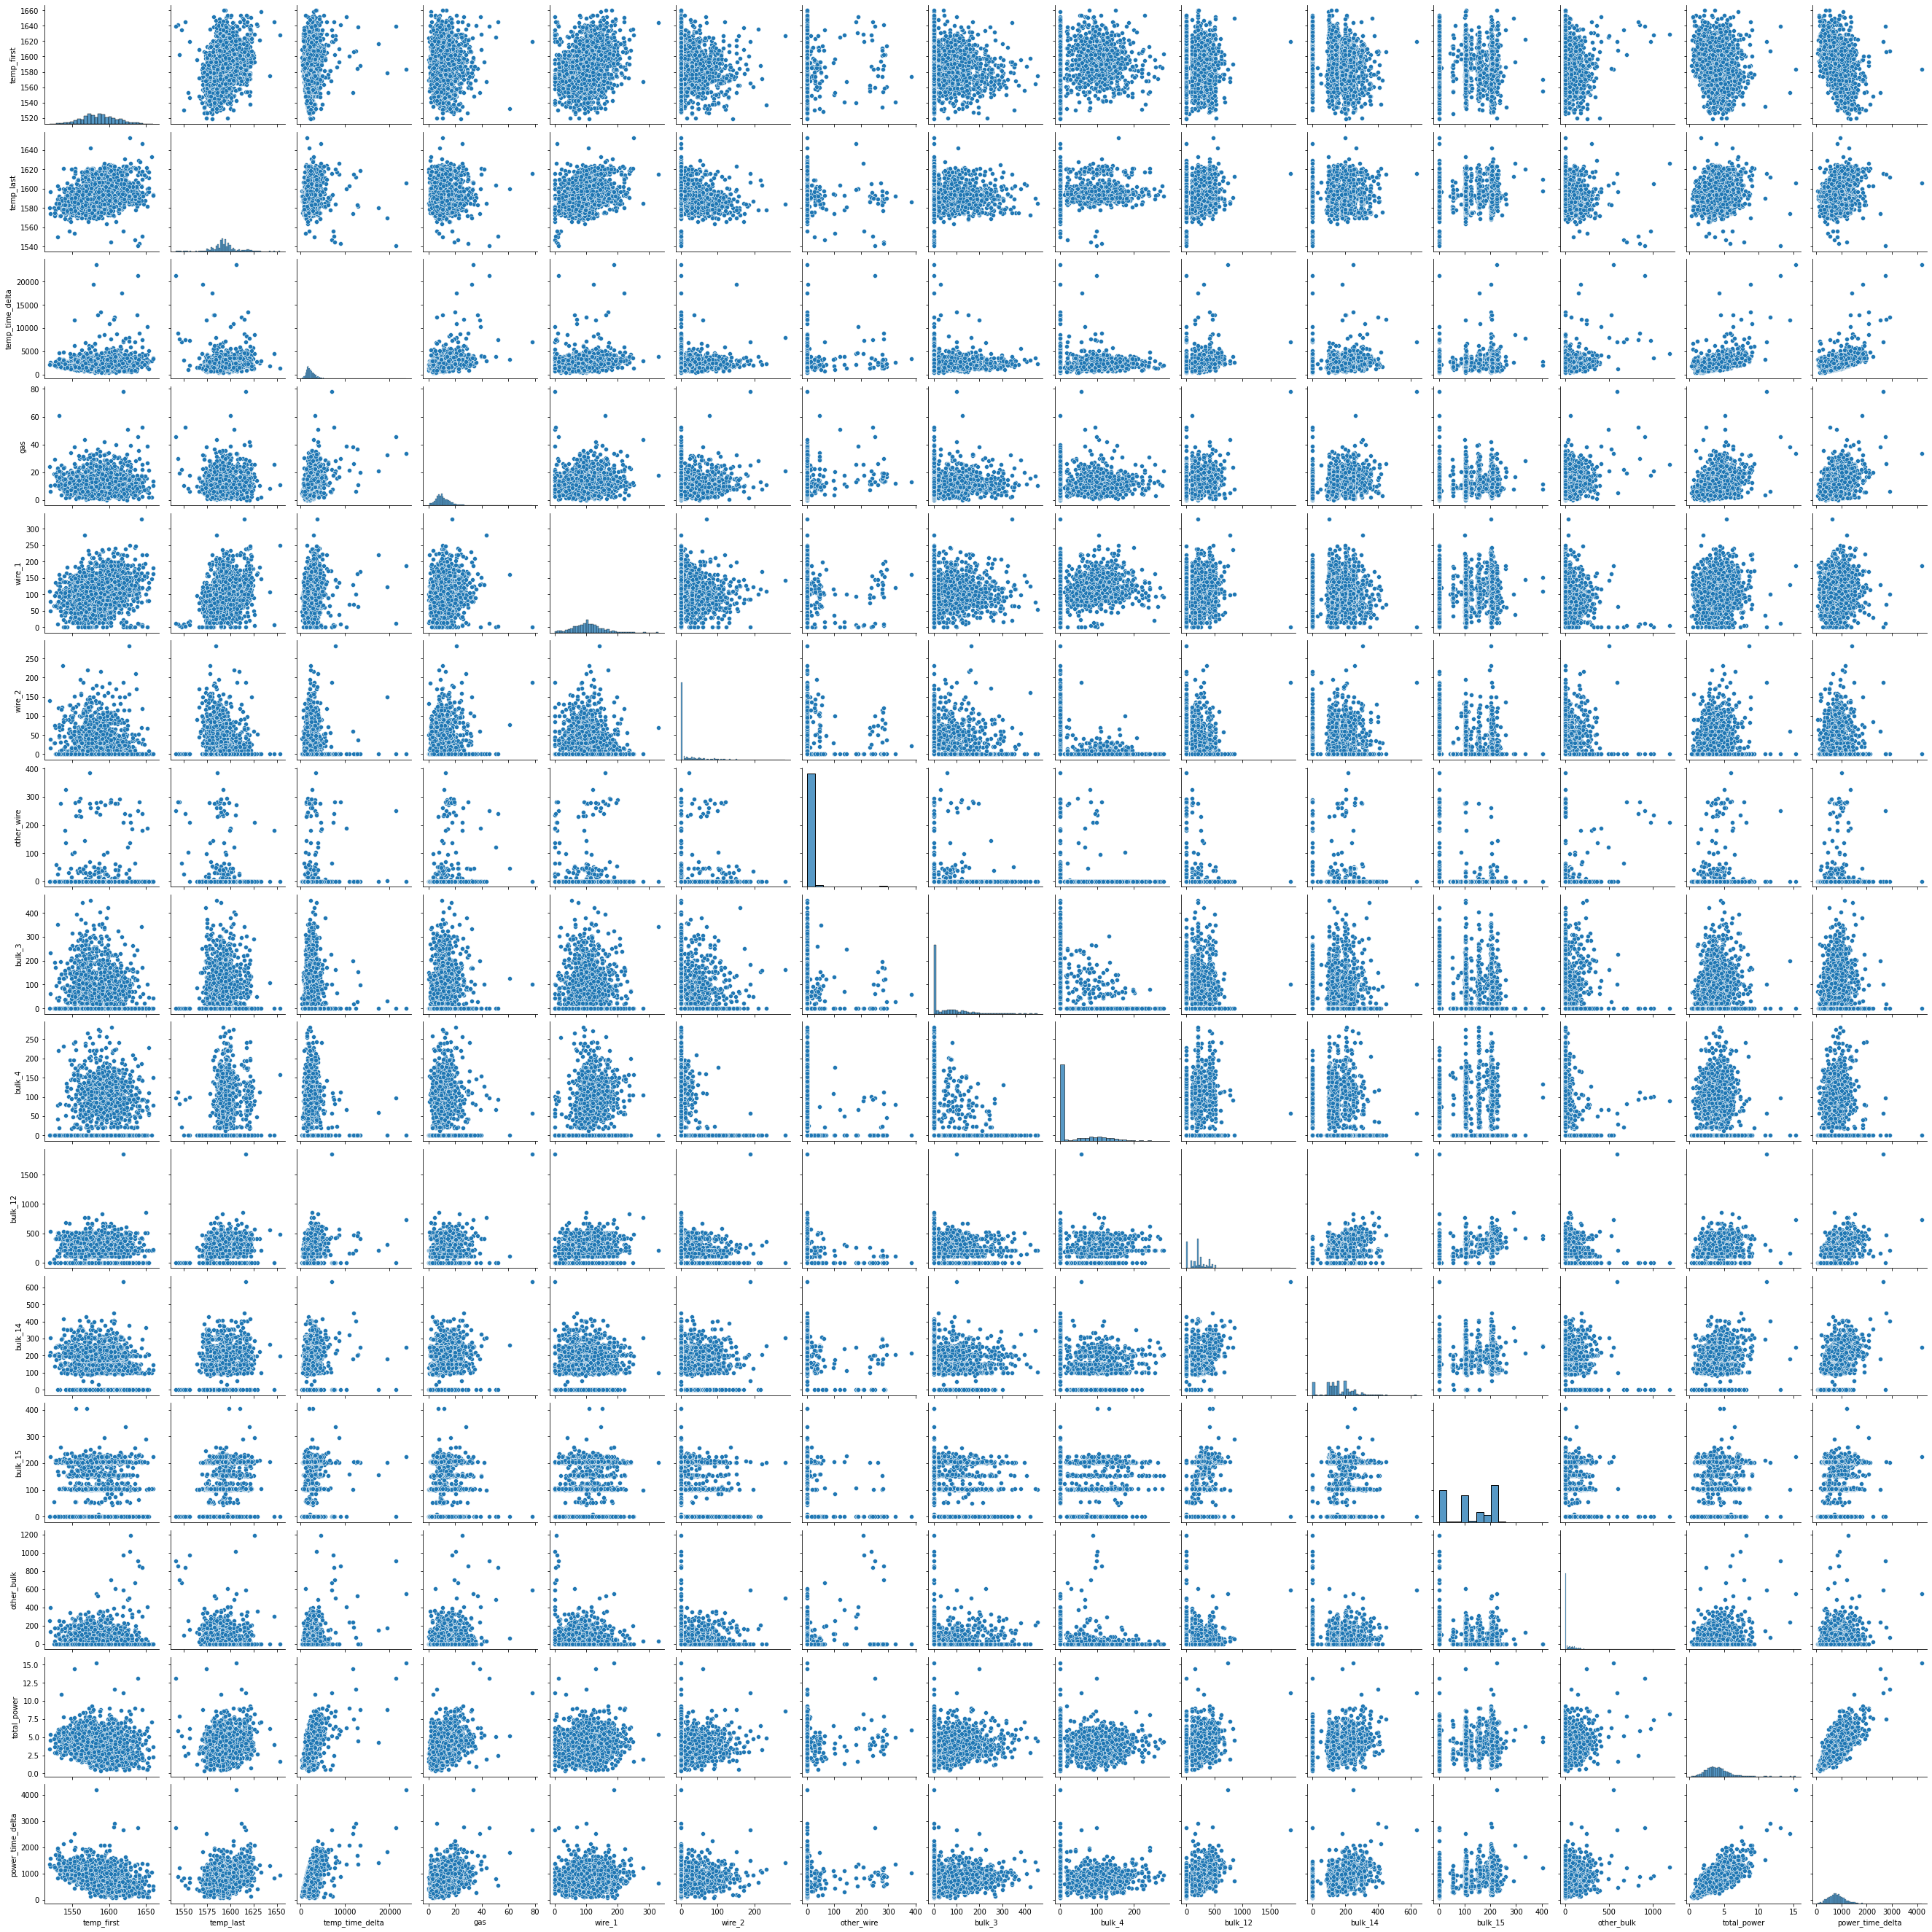

In [72]:
sns.pairplot(fdata)

Мультиколлинеарные признаки отсутствуют

### Подготовка к обучению

In [44]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

In [45]:
X = fdata.drop('temp_last', axis=1)
y = fdata['temp_last']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=RND_SEED)

In [47]:
for selection in [X_train, X_test, y_train, y_test]:
    print(selection.shape)

(1743, 14)
(581, 14)
(1743,)
(581,)


### Удаление выбросов

In [48]:
X_train = X_train[X_train['power_time_delta'] < 2000]
y_train = y_train.loc[X_train.index]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1735 entries, 1708 to 168
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp_first        1735 non-null   float64
 1   temp_time_delta   1735 non-null   float64
 2   gas               1735 non-null   float64
 3   wire_1            1735 non-null   float64
 4   wire_2            1735 non-null   float64
 5   other_wire        1735 non-null   float64
 6   bulk_3            1735 non-null   float64
 7   bulk_4            1735 non-null   float64
 8   bulk_12           1735 non-null   float64
 9   bulk_14           1735 non-null   float64
 10  bulk_15           1735 non-null   float64
 11  other_bulk        1735 non-null   float64
 12  total_power       1735 non-null   float64
 13  power_time_delta  1735 non-null   float64
dtypes: float64(14)
memory usage: 203.3 KB


## Обучение

### Random forest

In [49]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
params = {
        'n_estimators': range (50, 70, 5),
        'max_depth': range (8, 12, 1)
}

modelRF = RandomForestRegressor(random_state=RND_SEED)
gridRF = GridSearchCV(modelRF, params,cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
gridRF.fit(X_train_scaled, y_train)
print(-gridRF.best_score_)

6.203203904525853


### LightGBM

In [51]:
param_grid = {
    'n_estimators': [400, 500],
    'max_depth': [2, 3],
    'lambda_l1' : [0.05, 0.1],
    'lambda_l2' : [0.2, 0.3],
    'monotone_penalty' : [0.05, 0.1],
    'min_data_in_leaf' : [18, 20, 22, 25]
}


modelGB = lgb.LGBMRegressor(objective='regression', random_state=RND_SEED, extra_trees=True, verbose=-1)
gridGB = GridSearchCV(modelGB, param_grid, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_absolute_error')
gridGB.fit(X_train, y_train)
print(-gridGB.best_score_)

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightG

### Тестирование

В ходе обучения моделей получились следующие результаты:

MAE на модели случайного леса 6,20

МАЕ на LGBM 5,86

Сильнее оказалась модель градиентного бустинга. Проведем тестирование модели:

In [52]:
print(mean_absolute_error(y_test, gridGB.predict(X_test)))

5.5977668044991935


In [53]:
print(r2_score(y_test, gridGB.predict(X_test)))

0.5036460924607393


### Dummy test

In [54]:
dummy = DummyRegressor().fit(X_train, y_train)

In [55]:
print(mean_absolute_error(y_test, dummy.predict(X_test)))

7.697827952402438


### Важность фичей

In [56]:
importance = gridGB.best_estimator_.feature_importances_

In [57]:
_ = columns_name.pop(1)

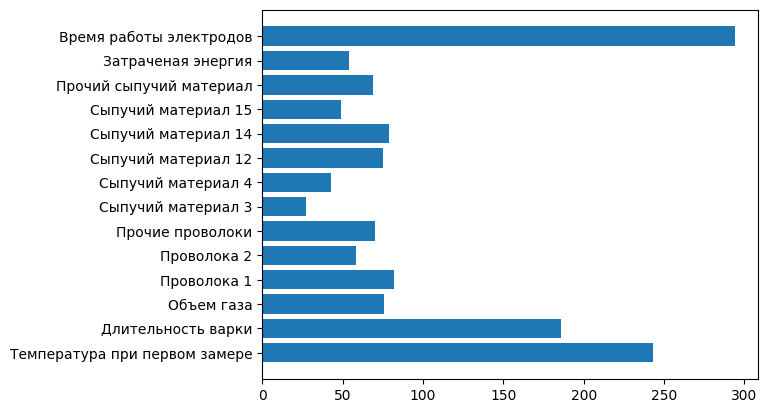

In [58]:
plt.barh(columns_name, importance);

Важными данными являются время работы электродов, температура первого замера, длительность варки. 
Так же важен совокупный набор примесей, добавляемых в ковш. Объем газа и затраченная энергия меньше влияют на предсказания.

In [59]:
endtime = time.time()
print('Время выполнения проекта {} минут'.format((endtime-starttime) //60))

Время выполнения проекта 0.0 минут


## Вывод

В ходе работы были проанализированы и предобработаны данные: удалены пропуски, созданы новые фичи, объеденены данные в единый фрейм, рассмотрены представленные данные на графиках и выделены выбросы. Построены модели: случайного леса и градиентного бустинга с тюнингом параметров через GridSearchCV. 
Лучшая модель была протестирована на адекватость и рассмотрена важность фичей. 
Модель дала следующие результаты:

- MAE: 5.6
- R2: 0.50

## Отчет

### План

Работа выполнена в соответствии с планом, с небольшими отклонениями. Ниже еще раз план работ и пояснения:


<div>
<h2>План проекта<a class="tocSkip"></h2>
    <h3> Препроцессинг<a class="tocSkip"></h3>
                
* ✅ Удалить партии: с неизмеренной температурой, с отрицательными значениями мощности, с одним измерением температуры, со значениями температуры <1500
* ✅ Пересчиать мощность в абсолютные значения
* ✅ Выделить первый и последний замер в проверке температур
* 🤔 Посчитать совокупный объем сыпучих метериалов и количество проволоки - Здесь работа пошла более сложным путем, были выделены регулярные материалы и редкоприменяемые(частота < 20%). Последние были собраны в один столбец. Так сохранился источник материала на случай разной степени воздействия и убраны редкие фичи, на которых модель могла некорректно обучится.
* ✅ Слепить данные в единую таблицу
* ✅ Убрать ключи
* ✅ Вывести корреляцию призаков
* ✅ Разобраться с мультиколлинеарными признаками
* ✅⬆️ Визуализировать значения признаков - сделал чуть раньше
* ✅ Поделить датасет
* ✅ Отскалировать фичи
* Так - же здесь на основании визуального представления были выделены выбросы, которые были удалены на тренировочной выборке.

<h3>Построение моделей<a class="tocSkip"></h3>

* ✅ Построить модель случайного леса с перебором гиперпараметров
* ✅ Построить модель градиентного бустинга с перебором гиперпараметров
* ✅⬇️ Построить дамми модель - построена там-же где и применена.
* ✅ Выделить сильную модель

<h3>Подведение итогов<a class="tocSkip"></h3>

* ✅ Проверить модель на тестовой выборке
* ❌ Изучить процесс обучения - модель градиентного бустинга на 500 деревьях никак не представить.
* ✅ Провести дамми тест
* 🟡 Провести анализ важности фичей - изучена степень влияния, но не изучен характер. Стоит разобраться в работе SHAP
* ✅ Подвести итог работы

### Трудности

Работа в целом прошла легко и достаточно гладко, можно отметить достаточно маленькую вычислительную мощность выделяемую jupyter'ом для тюнинга гиперпараметров модели. Для начала был запущен подбор гиперпараметров через RandomizedHalvingGridSearchCV с дальнейшей небольшой подстройкой оптимальной конфигурации(из проекта убрал, что-бы не отнимать время) 

### Ключевые шаги

- Сборка данных в датасет - важный и требующий осторожности процесс, важно не допустить утечки признаков, и правильно подготовить таблицы для слияния. 
- Выявление и удаление аномалий - выявленные аномалии были удалены на тренировочной выборке, что позволило снизить ошибку на примерно 0.4пункта (градуса).
- Важность фичей - данный график позволяет донастроить модель в случае, если это потребуется: можно подкрутить веса, или удалить некоторые признаки со слабым влиянием.

### Признаки

- Температура при первом замере и Температура при последнем замере: Были выброшены значения из каждой варки < 1500 и в набор попали только те значения, в варках которых было 2 и более замера. Отделены значения через группировку по варке с аггрегацией по ключам first и  last
- Длительность варки: дельта времени полученная разностью во времени последнего и первого измерения, переведено в секунды.
- Объем газа: здесь ничего не менялось
- Проволока 1, Проволока 2, прочие проволоки: последний столбец получен путем суммирования редкоиспользуемой проволоки, остальное без изменений
- Сыпучий материал х, прочий сыпучий материал: последний столбец получен путем суммирования редкоиспользуемой проволоки, материал 3,4,12,14,15 без изменений
- Затраченая энергия: получена по формуле (активная мощность^2 + реактивная мощность^2)^0.5 и просуммирована по каждому циклу нагрева, было найдено отрицательное значение мощности с очень высоким значением. Варка с этим значеним была удалена.
- Время работы электродов: сумма затраченного времени на нагрев по каждой варке

### Модель

Представлена модель LightGBM с включенным параметром extra_trees. Опимизировалась по значениею метрики МАЕ
Обученая модель приняла следующие гиперпараметры:

In [60]:
gridGB.best_params_

{'lambda_l1': 0.1,
 'lambda_l2': 0.2,
 'max_depth': 2,
 'min_data_in_leaf': 22,
 'monotone_penalty': 0.05,
 'n_estimators': 500}

Random_state зафиксирован следующим значением:

In [61]:
RND_SEED

250923

Метрика MAE: 5.6, R2 50%